In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pathlib
import scipy.io as sio
from os.path import dirname, join as pjoin
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
import imageio
from PIL import Image

In [8]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

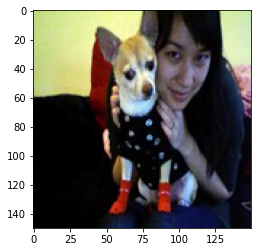

In [27]:
from skimage.color import rgb2gray
im1 = Image.open(pathlib.Path().joinpath('Images/n02085620-Chihuahua/n02085620_7.jpg').absolute())
im1 = im1.resize((150,150))

plt.imshow(im1)

# train test split 80% - 20%

In [ ]:
if not os.path.exists('train'):
    os.makedirs('train')
    creation = True
if not os.path.exists('test'):
    os.makedirs('test')
    creation = True

for repertoir in os.listdir('Images'):
    if not os.path.exists('train/'+repertoir):
        os.makedirs('train/'+repertoir)
    if not os.path.exists('test/'+repertoir):
        os.makedirs('test/'+repertoir)

    tmp_data = os.listdir(pathlib.Path().joinpath('Images/'+repertoir).absolute())
    x_train, x_test = train_test_split(tmp_data, test_size = 0.2)

    for img1 in x_train:
        #img = reductionDimentsion(pathlib.Path().joinpath('Images/'+repertoir+'/'+img1).absolute())
        #Image.fromarray(img).convert('L').save(pathlib.Path().joinpath('train/'+repertoir+'/'+img1).absolute())
        copyfile(pathlib.Path().joinpath('Images/'+repertoir+'/'+img1).absolute(), pathlib.Path().joinpath('train/'+repertoir+'/'+img1).absolute())
    for img2 in x_test:
        #img = reductionDimentsion(pathlib.Path().joinpath('Images/'+repertoir+'/'+img2).absolute())
        #Image.fromarray(img).convert('L').save(pathlib.Path().joinpath('train/'+repertoir+'/'+img2).absolute())
        copyfile(pathlib.Path().joinpath('Images/'+repertoir+'/'+img2).absolute(), pathlib.Path().joinpath('test/'+repertoir+'/'+img2).absolute())

In [ ]:
training_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train = training_data.flow_from_directory(
    pathlib.Path().joinpath('Train').absolute(),
    target_size=(150,150),
    class_mode='categorical'
)

test = training_data.flow_from_directory(
    pathlib.Path().joinpath('test').absolute(),
    target_size=(150,150),
    class_mode='categorical'
)

# Reduction de dimension des images

## whitening equalization

In [ ]:
from whitening import whiten
import matplotlib.image as mpimg
import PIL.Image

def whitening(img):
    image = PIL.Image.open(img)
    foreground, background = whiten(image, kernel_size=20, downsample=4)
    foreground.save(img, 'jpeg')
                                    
# image = plt.show('Images/n02085620-Chihuahua/'+tmp_data[0])
# foreground, background = whiten(image, kernel_size=20, downsample=4)
# foreground.save('foreground.jpg', 'jpeg')


# On s'occupe des images dans train  
directory_train = 'train/'  
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        a = os.path.join(subdir, file)
        whitening(a)

# # On s'occupe des images dans test
directory_test= 'test/' 
for subdir, dirs, files in os.walk(directory_test):
    for file in files:
        a = os.path.join(subdir, file)
        whitening(a)

# augmention du train 
### zoom, decalage 

# Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax') 
])

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

# Entrainement du model

In [ ]:
history = model.fit(train,
                    epochs=100, 
                   validation_data=train, 
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                               tfdocs.modeling.EpochDots()])

# Sauvegarde du model

In [ ]:
model.save('snooky.h5')

# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(test)

# Courbe d'apprentissage

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mae'], label="train")
plt.plot(history.history['val_mae'], label="test")
plt.title('mean absolute error')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
plt.plot(history.history['mse'], label="train")
plt.plot(history.history['val_mse'], label="test")
plt.title('mean squarre error')
plt.ylabel('MSE [MPG^2]')
plt.xlabel('epoch')
plt.ylim([0,20])
plt.legend()
plt.show()

# Load du model

In [ ]:
model = load('snooky.h5')

# Prediction

In [ ]:
img = mpimg.imread("monimage.png")

prediction = model.predict(img)

plt.bar(range(120),predictions[0])
#plt.xticks(range(120), class_names, rotation=45)